In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import sys, copy, emcee, corner
%matplotlib inline

In [2]:
sys.path.append('./ligbind/')
import ligbind as lb

In [3]:
def wym_obj(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)

def fit_wym(guess,model,data,ligs,rtot,bnds):
        return sp.optimize.least_squares(wym_obj,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14)
    
def wym_obj_wt(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)/datac

def fit_wym_wt(guess,model,data,ligs,rtot,bnds):
        return sp.optimize.least_squares(wym_obj_wt,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14)

In [4]:
def wymfunc_fix(parm,lig,rtot):
    '''
    Model function for dimerizing, single-site receptors as derived in
    (Wyman and Gill, Binding and Linkage, 1990) and used by
    (Macdonald and Pike, ...EGF-binding...negative cooperativity...aggregating system, 2008).
    Takes numpy array of parameters [k11,k21,k22,l20], numpy array of free ligand concentrations,
    and total receptor concentration. Returns the fraction of receptor bound to ligand.

    To generate a data set, iterate over an array of desired receptor concentrations, e.g.:
    [wymfunc(parm,lig,i) for i in array_of_rtots]

    For use in curve fitting an objective function for use with scipy.optimize.least_squares
    is readily constructed as: (wymfun(parm_guess,lig,rtot) - actual_data)
    '''

    #ensure dimension/broadcasting compatibility of inputs
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        rtot = rtot[:,None] #adds dimension so that it can be broadcast
    else:
        rtot = rtot

    #unpack parameters
    k11 = parm[0]
    k21 = parm[1]
    k22 = k21/4.
    l20 = parm[2]

    ### START MODEL FUNCTION ###

    #calculate concentration of free (unoccupied) receptor
    rfree = (((-1 - k11*lig)) + \
    ((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))**0.5) \
    / (4*l20*(1 + k21*lig + k21*k22*(np.square(lig))))

    #calculate bound fraction
    bfrac = (k11*lig + l20*k21*rfree*lig + \
    2*l20*k21*k22*rfree*(np.square(lig))) \
    / (1 + 2*l20*rfree + k11*lig + \
    2*l20*k21*rfree*lig + 2*l20*k21*k22*rfree*(np.square(lig)))

    ### END MODEL FUNCTION ###

    #flatten output
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        return bfrac.flatten()
    elif (rtot.ndim == 0):
        return bfrac.flatten()
    else:
        return np.concatenate(bfrac)

In [134]:
from itertools import product

def parmsetter(k1):
    base = np.array([k1,])
    k2s = np.array([0.1,1.,10.])*base
    k21s = np.array([1000.,100.,10.,0.1,0.01,0.001])*base
    ls = np.array([10.,100.,1000.])*base
    
    things = [base,k2s,k21s,ls]
    
    b = list(product(*things))
    
    c = np.array(b)
    
    c[:,2]=c[:,1]/4.
    
    neuts = np.array(list(set([tuple(i.tolist()) for i in c])))
    
    all_sets = np.concatenate([b,neuts])
    
    return all_sets

In [135]:
parmsets = parmsetter(5)

In [136]:
sim_n05 = [lb.WymSim(sets=1000,reps=1,parms=i,noise=0.05) for i in parmsets]

In [8]:
guess = np.array([5.,2.,0.5,500.])
guess_fix = np.array([5.,2.,500.])

In [9]:
lsbnds = (tuple(1e-5 for i in range(4)),tuple(1e4 for i in range(4)))
lsbnds_fix = (tuple(1e-5 for i in range(3)),tuple(1e4 for i in range(3)))

In [42]:
#res05_full_wt = [np.array([fit_wym_wt(guess,lb.models.wymfunc,i,j.ligs,j.rtot,lsbnds) for i in j.meanset]) for j in sim_n05]

In [51]:
#res05_fix_wt = [np.array([fit_wym_wt(guess_fix,wymfunc_fix,i,j.ligs,j.rtot,lsbnds_fix) for i in j.meanset]) for j in sim_n05]

In [58]:
%store lsbnds

Stored 'lsbnds' (tuple)


In [60]:
t = np.array(res05_fix_wt)

In [61]:
%store t

Stored 't' (ndarray)


In [62]:
u = np.array(res05_full_wt)

In [63]:
%store u

Stored 'u' (ndarray)


In [10]:
%store -r t

In [14]:
t[0][0].x

array([  5.06221901,   0.91752248,  66.81683739])

In [15]:
%store -r u

In [23]:
u[0].shape

(1000,)

In [24]:
u.shape

(63, 1000)

In [25]:
def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [30]:
ps = np.array([np.array([ftest(t[j][i],u[j][i])[-1] for i in range(1000)]) for j in range(63)])

In [36]:
sigs = np.array([np.sum(ps[i] < 0.05) for i in range(63)])

In [54]:
berb = np.array([i for i in enumerate(sigs)])

In [119]:
np.std(sigs)

19.507594247065374

In [56]:
np.sort(berb,axis=0)

array([[ 0,  6],
       [ 1, 13],
       [ 2, 15],
       [ 3, 15],
       [ 4, 16],
       [ 5, 19],
       [ 6, 21],
       [ 7, 25],
       [ 8, 32],
       [ 9, 33],
       [10, 33],
       [11, 35],
       [12, 37],
       [13, 41],
       [14, 52],
       [15, 53],
       [16, 54],
       [17, 54],
       [18, 57],
       [19, 57],
       [20, 59],
       [21, 60],
       [22, 60],
       [23, 60],
       [24, 60],
       [25, 60],
       [26, 61],
       [27, 61],
       [28, 61],
       [29, 62],
       [30, 62],
       [31, 63],
       [32, 63],
       [33, 64],
       [34, 64],
       [35, 65],
       [36, 66],
       [37, 66],
       [38, 66],
       [39, 68],
       [40, 68],
       [41, 69],
       [42, 69],
       [43, 69],
       [44, 70],
       [45, 70],
       [46, 70],
       [47, 70],
       [48, 71],
       [49, 71],
       [50, 73],
       [51, 73],
       [52, 74],
       [53, 74],
       [54, 74],
       [55, 74],
       [56, 75],
       [57, 75],
       [58, 75

In [74]:
berb[berb[:,1].argsort()]

array([[15,  6],
       [56, 13],
       [12, 15],
       [ 3, 15],
       [ 9, 16],
       [ 0, 19],
       [ 6, 21],
       [13, 25],
       [ 7, 32],
       [61, 33],
       [16, 33],
       [ 1, 35],
       [10, 37],
       [ 4, 41],
       [ 5, 52],
       [51, 53],
       [ 8, 54],
       [22, 54],
       [57, 57],
       [48, 57],
       [62, 59],
       [40, 60],
       [30, 60],
       [39, 60],
       [38, 60],
       [58, 60],
       [23, 61],
       [53, 61],
       [37, 61],
       [45, 62],
       [27, 62],
       [ 2, 63],
       [14, 63],
       [36, 64],
       [25, 64],
       [50, 65],
       [43, 66],
       [52, 66],
       [26, 66],
       [42, 68],
       [24, 68],
       [18, 69],
       [54, 69],
       [31, 69],
       [32, 70],
       [28, 70],
       [47, 70],
       [34, 70],
       [20, 71],
       [11, 71],
       [29, 73],
       [17, 73],
       [59, 74],
       [21, 74],
       [35, 74],
       [19, 74],
       [44, 75],
       [49, 75],
       [41, 75

In [61]:
parmsets[15]

array([  5.   ,   0.5  ,   0.125,  50.   ])

In [62]:
parmsets[33]

array([  5.  ,   5.  ,   1.25,  50.  ])

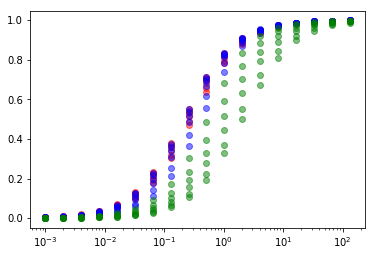

In [77]:
plt.semilogx(sim_n05[33].ligs, sim_n05[33].bfrac,'o',color='red',alpha=0.5)
plt.semilogx(sim_n05[15].ligs, sim_n05[15].bfrac,'o',color='blue',alpha=0.5)
plt.semilogx(sim_n05[2].ligs, sim_n05[2].bfrac,'o',color='green',alpha=0.5)

In [78]:
ps

array([[  9.65810645e-01,   1.51676225e-01,   3.63257767e-01, ...,
          3.15030151e-01,   2.79188265e-01,   4.34721238e-01],
       [  3.88582811e-01,   5.81532414e-01,   3.13576715e-01, ...,
          7.38953980e-01,   3.30469006e-01,   1.14204716e-01],
       [  5.90967987e-01,   8.90974691e-01,   5.06455225e-01, ...,
          3.73103624e-02,   2.56315908e-01,   4.49965167e-01],
       ..., 
       [  4.59767547e-02,   9.19985051e-04,   6.10361176e-01, ...,
          5.10447246e-01,   4.15439031e-01,   5.77626604e-02],
       [  9.56623873e-01,   6.86563442e-01,   5.71915489e-01, ...,
          6.22237045e-02,   3.58515958e-01,   6.98852984e-01],
       [  6.25345837e-01,   7.95669082e-01,   5.01945871e-01, ...,
          5.76680544e-01,   4.42684250e-01,   1.23998200e-02]])

In [79]:
ps.shape

(63, 1000)

In [81]:
sigs.shape

(63,)

In [82]:
parmsets

array([[  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+01],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+02],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+03],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+01],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+02],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+03],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+01],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+02],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+03],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+01],
       [  5.00000000e+00,   5.00000000e-01,   1.25000000e-01,
          5.00000000e+02],
       [  5.00000000e

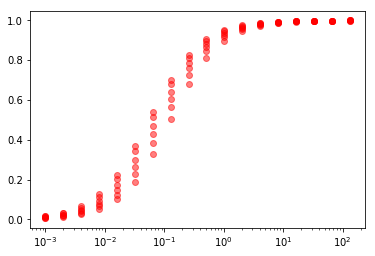

In [97]:
plt.semilogx(sim_n05[1].ligs, sim_n05[57].bfrac,'o',color='red',alpha=0.5);

In [98]:
a = lb.WymSimSubset()

In [100]:
a.ligs

array([[  1.00000000e-03,   2.00000000e-03,   4.00000000e-03,
          8.00000000e-03,   1.60000000e-02,   3.20000000e-02,
          6.40000000e-02,   1.28000000e-01,   2.56000000e-01,
          5.12000000e-01,   1.02400000e+00,   2.04800000e+00,
          4.09600000e+00,   8.19200000e+00,   1.63840000e+01,
          3.27680000e+01,   6.55360000e+01,   1.31072000e+02],
       [  1.00000000e-03,   2.00000000e-03,   4.00000000e-03,
          8.00000000e-03,   1.60000000e-02,   3.20000000e-02,
          6.40000000e-02,   1.28000000e-01,   2.56000000e-01,
          5.12000000e-01,   1.02400000e+00,   2.04800000e+00,
          4.09600000e+00,   8.19200000e+00,   1.63840000e+01,
          3.27680000e+01,   6.55360000e+01,   1.31072000e+02],
       [  1.00000000e-03,   2.00000000e-03,   4.00000000e-03,
          8.00000000e-03,   1.60000000e-02,   3.20000000e-02,
          6.40000000e-02,   1.28000000e-01,   2.56000000e-01,
          5.12000000e-01,   1.02400000e+00,   2.04800000e+00,
      

In [102]:
a.subset(0,7)

In [104]:
a.meanset

array([[[ 0.00287427,  0.00559022,  0.01093899, ...,  0.04084424,
          0.08085992,  0.14953276],
        [ 0.00247699,  0.00473858,  0.00908782, ...,  0.03997233,
          0.07324313,  0.14118587],
        [ 0.00226029,  0.00449576,  0.00860164, ...,  0.03409087,
          0.06747441,  0.12095041],
        [ 0.00200531,  0.00410486,  0.00782496, ...,  0.03046561,
          0.06105856,  0.1109866 ],
        [ 0.00177537,  0.00348527,  0.00684557, ...,  0.02639917,
          0.05040694,  0.09542783],
        [ 0.00150372,  0.00320088,  0.00591898, ...,  0.02442401,
          0.04646277,  0.08220534]],

       [[ 0.00272981,  0.00555536,  0.01095825, ...,  0.04292022,
          0.07876249,  0.14734646],
        [ 0.00238992,  0.00484733,  0.00967603, ...,  0.03734255,
          0.07331235,  0.13799986],
        [ 0.00217253,  0.00454356,  0.00877293, ...,  0.03556681,
          0.06403407,  0.13113658],
        [ 0.00190621,  0.00393526,  0.00801635, ...,  0.03225764,
          0.05

In [114]:
b = lb.WymSimSubset()

In [116]:
b.ligs[0].shape

(18,)

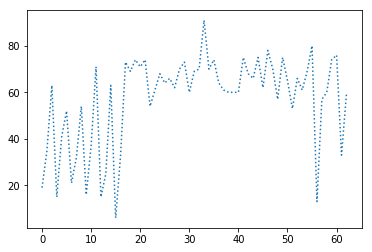

In [133]:
plt.plot(berb[:,0],berb[:,1],':',sho)

In [123]:
sigs

array([19, 35, 63, 15, 41, 52, 21, 32, 54, 16, 37, 71, 15, 25, 63,  6, 33,
       73, 69, 74, 71, 74, 54, 61, 68, 64, 66, 62, 70, 73, 60, 69, 70, 91,
       70, 74, 64, 61, 60, 60, 60, 75, 68, 66, 75, 62, 78, 70, 57, 75, 65,
       53, 66, 61, 69, 80, 13, 57, 60, 74, 76, 33, 59])